# **FLOWER CLASSIFICATION WITH TPUS (Kaggle Competition)**

# Installing and Importing Dependencies

In [1]:
!pip install efficientnet

     |████████████████████████████████| 50 kB 1.2 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import gc
import tensorflow as tf, tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets
import math, re, os
from sklearn.model_selection import KFold
import efficientnet.tfkeras as efn

AUTO = tf.data.experimental.AUTOTUNE
AUTO, tf.__version__

(-1, '2.2.0')

# TPU Detection

In [3]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()       # provides information about the TPU cluster - ip and port.
tf.config.experimental_connect_to_cluster(resolver)                  # Will make devices on the cluster available to use
tf.tpu.experimental.initialize_tpu_system(resolver)                  # Initialize the TPU devices.
strategy = tf.distribute.experimental.TPUStrategy(resolver)          # lets you run your TensorFlow training on Tensor Processing Units (TPUs)
print('Running on TPU ', resolver.cluster_spec().as_dict())
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  {'worker': ['10.0.0.2:8470']}
REPLICAS:  8


# Configuration

In [4]:
IMAGE_SIZE = [512, 512] 
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

classes = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']


In [5]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}

GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

In [6]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [7]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

BATCH_SIZE, STEPS_PER_EPOCH, NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES

(128, 128, 16465, 3712, 7382)

# Loading Images

In [8]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

In [9]:
def read_labelled_tfrec(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "class": tf.io.FixedLenFeature([], tf.int64),  
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    label = tf.cast(example['class'], tf.int32)
    return image, label 

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string), 
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0 
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    idnum = example['id']
    return image, idnum 

In [10]:
def read_dataset(filenames, labeled=True, ordered=False):
  ignore_order = tf.data.Options()
  if not ordered:
    ignore_order.experimental_deterministic = False                     # disable order, increase speed
  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # to read tf records, each tfrecord contains image encoded as bytes
  dataset = dataset.with_options(ignore_order)                          # uses data as soon as it streams in, rather than in its original order
  dataset = dataset.map(read_labelled_tfrec if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
  return dataset 
def read_train_data():
    dataset = read_dataset(TRAINING_FILENAMES, labeled=True)
    dataset =  dataset.map(data_augment, num_parallel_calls=AUTO)
    return dataset.repeat().shuffle(2048, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(AUTO) 

def read_validation_data(ordered=False):
    return read_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered).batch(BATCH_SIZE).cache().prefetch(AUTO)

def read_test_data(ordered=False):
    return read_dataset(TEST_FILENAMES, labeled=False, ordered=ordered).batch(BATCH_SIZE).prefetch(AUTO)

In [11]:
def get_training_dataset(dataset,do_aug=True):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if do_aug: dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat() 
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) 
    return dataset


# Dataset visualisation

In [12]:
np.set_printoptions(threshold=15, linewidth=80)

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
    
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return classes[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(classes[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                classes[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):

    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else classes[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

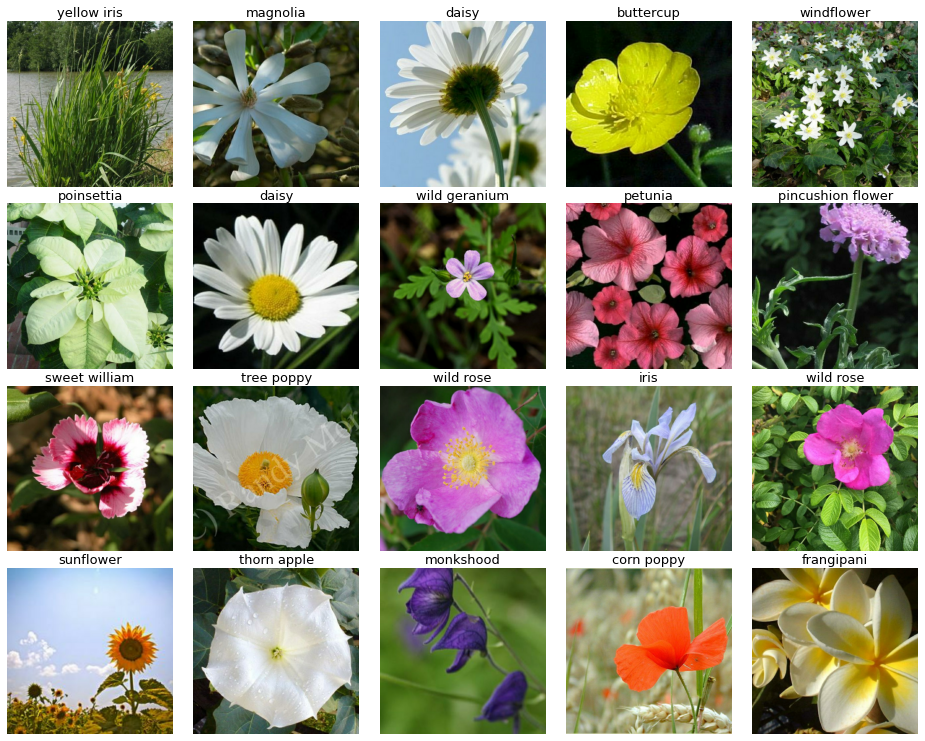

In [13]:
training_dataset = read_train_data()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)
display_batch_of_images(next(train_batch))

# Training and Prediction

In [14]:
LR_START = 0.0001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lr_scheduler_2(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = np.random.random_sample() * LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    

In [15]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler_2, verbose = True)

In [16]:
def tta(model, TTA_NUM = 10):
    probabilities = []
    for i in range(TTA_NUM):
        print('TTA Number: ',i)
        test_ds = read_test_data(ordered=True) 
        test_images_ds = test_ds.map(lambda image, idnum: image)
        gc.collect()
        probabilities.append(model.predict(test_images_ds,verbose =1))
    prob2 = np.mean(probabilities,axis =0)
    return prob2

In [17]:
import gc
def train_and_predict(models, TTA_NUM = 10):
    test_ds = read_test_data(ordered=True) 
    test_images_ds = test_ds.map(lambda image, idnum: image)
    print('Computing predictions...')
    print("TTA")
    probability = ([tta(models[i], TTA_NUM) for i in range(len(models))])
    probabilities = np.average(probability, axis = 0)
    predictions = np.argmax(probabilities, axis=-1)
    print(predictions)
    gc.collect()
    print('Generating submission.csv file...')
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
    np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
    return models

## **EfficientNetB7**

In [18]:
 def get_model1():
    with strategy.scope():
        enet = efn.EfficientNetB7(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 3),
            weights='noisy-student',
            include_top=False
        )

        model = tf.keras.Sequential([
            enet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(classes), activation='softmax')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss = 'sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )
   
    return model

## **DenseNet201**

In [19]:
 def get_model2():
    with strategy.scope():
        enet = tf.keras.applications.DenseNet201(weights='imagenet', 
                                                 include_top=False,
                                                input_shape=[*IMAGE_SIZE, 3])

        model = tf.keras.Sequential([
            enet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(classes), activation='softmax')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss = 'sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )
   
    return model

In [20]:
SEED = 25
TTA_NUM = 10
EPOCHS_1 = 32
EPOCHS_2 = 20

In [21]:
models = []

In [22]:
enet_model = get_model1()
history = enet_model.fit(read_train_data(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS_1, 
            callbacks = [lr_callback])

models.append(enet_model)

258072576/258068648 [==============================] - 3s 0us/step

Epoch 00001: LearningRateScheduler reducing learning rate to 4.7610742856653415e-05.
Epoch 1/32
128/128 [==============================] - 118s 920ms/step - loss: 3.9107 - sparse_categorical_accuracy: 0.2205 - lr: 4.7611e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 7.30219833103594e-05.
Epoch 2/32
128/128 [==============================] - 118s 920ms/step - loss: 2.2071 - sparse_categorical_accuracy: 0.5151 - lr: 7.3022e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 7.869965276703572e-05.
Epoch 3/32
128/128 [==============================] - 118s 924ms/step - loss: 1.0875 - sparse_categorical_accuracy: 0.7562 - lr: 7.8700e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 7.87485409662484e-05.
Epoch 4/32
128/128 [==============================] - 118s 922ms/step - loss: 0.6510 - sparse_categorical_accuracy: 0.8511 - lr: 7.8749e-05

Epoch 00005: LearningRateSchedule

In [23]:
dnet_model = get_model2()
history = dnet_model.fit(read_train_data(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS_2, 
            callbacks = [lr_callback])
models.append(dnet_model)

74842112/74836368 [==============================] - 1s 0us/step

Epoch 00001: LearningRateScheduler reducing learning rate to 6.984826238179045e-05.
Epoch 1/20
128/128 [==============================] - 62s 483ms/step - loss: 2.1625 - sparse_categorical_accuracy: 0.5456 - lr: 6.9848e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 6.0358344117491406e-05.
Epoch 2/20
128/128 [==============================] - 62s 482ms/step - loss: 0.7883 - sparse_categorical_accuracy: 0.8502 - lr: 6.0358e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 8.427117344926344e-05.
Epoch 3/20
128/128 [==============================] - 62s 482ms/step - loss: 0.4483 - sparse_categorical_accuracy: 0.9160 - lr: 8.4271e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 6.684042885796645e-05.
Epoch 4/20
128/128 [==============================] - 61s 476ms/step - loss: 0.2592 - sparse_categorical_accuracy: 0.9558 - lr: 6.6840e-05

Epoch 00005: LearningRateScheduler re

In [24]:
model_h = train_and_predict(models, TTA_NUM)

Computing predictions...
TTA
TTA Number:  0
58/58 [==============================] - 24s 418ms/step
TTA Number:  1
58/58 [==============================] - 15s 257ms/step
TTA Number:  2
58/58 [==============================] - 15s 255ms/step
TTA Number:  3
58/58 [==============================] - 15s 255ms/step
TTA Number:  4
58/58 [==============================] - 15s 253ms/step
TTA Number:  5
58/58 [==============================] - 15s 254ms/step
TTA Number:  6
58/58 [==============================] - 15s 253ms/step
TTA Number:  7
58/58 [==============================] - 15s 255ms/step
TTA Number:  8
58/58 [==============================] - 15s 253ms/step
TTA Number:  9
58/58 [==============================] - 15s 254ms/step
TTA Number:  0
58/58 [==============================] - 24s 414ms/step
TTA Number:  1
58/58 [==============================] - 11s 193ms/step
TTA Number:  2
58/58 [==============================] - 12s 198ms/step
TTA Number:  3
58/58 [==========================

**References**
* https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
* https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96